In [1]:
import numpy as np
import qibo
from boostvqe.models.dbi.group_commutator_iteration_transpiler import DoubleBracketRotationType

In [2]:
from boostvqe.utils import *
gci = initialize_gci_from_vqe()
print_vqe_comparison_report(gci)

[Qibo 0.2.9|INFO|2024-06-21 15:06:44]: Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-21 15:06:44]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy
VQE energy is -14.8569 and the DBQA yields -14.8569. 
The target energy is -15.27613 which means the difference is for VQE 0.41923 and of the DBQA 0.41923 which can be compared to the spectral gap 1.08767.
The relative difference is for VQE 2.74436% and for DBQA 2.74436%.The energetic fidelity witness for the ground state for the
VQE is 0.61456 
and DBQA 0.61456
The true fidelity is 0.00229 (see boostvqe issue https://github.com/qiboteam/boostvqe/issues/51 why this value seems wrong)
and DBQA 0.61456
The boosting circuit used 0 CNOT gates coming from compiled XXZ evolution and 70 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 0.0 and n_CZ/n_qubits = 7.0


In [3]:
from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
b_list = [1+np.sin(x/3)for x in range(10)]
eo_d_m_field = MagneticFieldEvolutionOracle(b_list)
eo_d_nn = IsingNNEvolutionOracle(b_list, b_list)

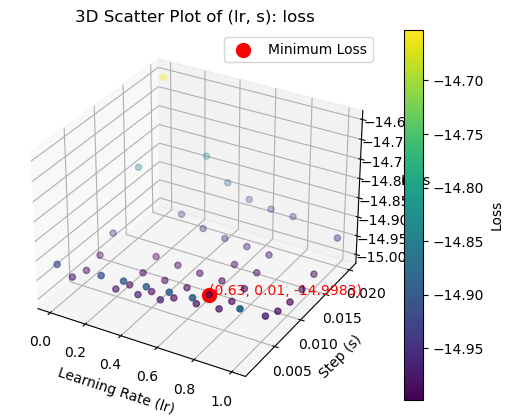

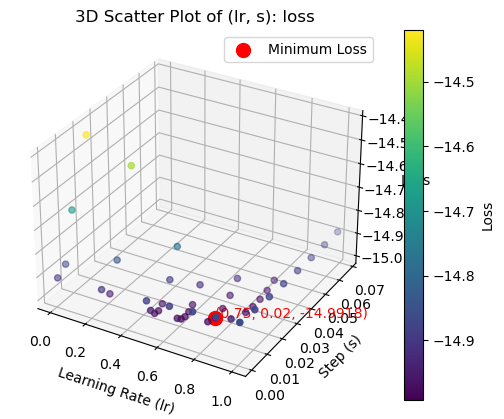

In [4]:
mode_dbr, minimizer_s, eo_d = select_recursion_step_gd_circuit(
    gci, mode_dbr_list = [DoubleBracketRotationType.group_commutator_third_order_reduced, 
                          DoubleBracketRotationType.group_commutator],
    eo_d = eo_d_nn,
    use_gd = True,
    step_grid = np.linspace(1e-3,2e-2,10),
    please_be_visual = True)
